# Movie ROI Project
##### By: Joshua Ko

## What drives the ROI of movies?

In order to answer this question my first step is to gather data. For this particular project, I used the data supplied by '_The Numbers_', '_The Movies Database_', and '_IMDB_'. Once the data is cleaned and successfully merged, I will be able to see if there are relationships between the ROI and some independent variable (genre, directors, or actors/actresses).

In [1]:
#Import some libraries
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, StrMethodFormatter

import seaborn as sns

My data folder holds two csv files stored: movie ratings and budget.

In [2]:
#Import dataframes using pandas
movie_ratings = pd.read_csv('Data/tmdb.movies.csv.gz')
budget = pd.read_csv('Data/tn.movie_budgets.csv.gz')

## Data Cleaning
The dataframes should always undergo a data cleaning step as real world data is very messy. Some steps includes getting rid or replacing null values, fixing date columns, specific values in rows, etc. Some data cleaning steps are listed below:

### Data cleaning `movie_ratings` dataframe

In [3]:
#Drop the 'Unnamed: 0' column as it provides no useful values
movie_ratings = movie_ratings.drop('Unnamed: 0', axis=1)

#Changing the movie title so that we can merge with the databases along 'movie'
movie_ratings = movie_ratings.replace('Star Wars: The Last Jedi', 'Star Wars Ep. VIII: The Last Jedi')
movie_ratings = movie_ratings.replace('Star Wars: The Force Awakens', 'Star Wars Ep. VII: The Force Awakens')

#Thinning out the data so it only includes data with a significant amount of votes
movie_ratings = movie_ratings[movie_ratings.vote_count >= 50]

#The date has to be changed from 'object' to 'datatime'
movie_ratings['release_date'] = pd.to_datetime(movie_ratings['release_date'])

#Convert the data column to a string
movie_ratings['release_date'] = movie_ratings['release_date'].dt.strftime('%b %d, %Y')

#Renaming the column so the databases can be merged along the column 'movie'
movie_ratings = movie_ratings.rename(columns={'original_title': 'movie'})
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5108 entries, 0 to 25148
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          5108 non-null   object 
 1   id                 5108 non-null   int64  
 2   original_language  5108 non-null   object 
 3   movie              5108 non-null   object 
 4   popularity         5108 non-null   float64
 5   release_date       5108 non-null   object 
 6   title              5108 non-null   object 
 7   vote_average       5108 non-null   float64
 8   vote_count         5108 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 399.1+ KB


In [4]:
#Drop irrelevant columns
movie_ratings = movie_ratings.drop(['genre_ids', 'id', 'original_language', 'title'], axis=1)

### Data cleaning budget dataframe

In [5]:
def convert_strings(df, col_name):
    # Removing symbol
    df[col_name] = df[col_name].map(lambda x: x.lstrip('$'))
    # Remove commas
    df[col_name] = df[col_name].replace(',', '', regex=True)
    # Convert to float
    df[col_name] = df[col_name].astype('float64')

In [6]:
col_names = ['production_budget', 'domestic_gross', 'worldwide_gross']
for x in col_names:
    convert_strings(budget, x)

In [7]:
#Create a new column of values that shows us the profits made for each movie
budget['ROI'] = budget['domestic_gross'] + budget['worldwide_gross'] - budget['production_budget']

#A column that contains the percent change
budget['Percent_change'] = (budget['ROI'] / budget['production_budget'] *100)

#Check columns and rows
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
 6   ROI                5782 non-null   float64
 7   Percent_change     5782 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 361.5+ KB


Upon further inspection, some rows hold no values for both `domestic_gross` and `worldwide_gross`, and should be removed.

In [8]:
budget = budget[(budget['domestic_gross'] > 0) & (budget['worldwide_gross'] > 0)]

#We can check how many rows were removed as a result of this line of code.
budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5234 non-null   int64  
 1   release_date       5234 non-null   object 
 2   movie              5234 non-null   object 
 3   production_budget  5234 non-null   float64
 4   domestic_gross     5234 non-null   float64
 5   worldwide_gross    5234 non-null   float64
 6   ROI                5234 non-null   float64
 7   Percent_change     5234 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 368.0+ KB


Now that the dataframes have been cleaned, we can merge the two using `outer` so that we can preserve as many rows as we can.
Just in case there are different movies with the same title, we can merge both dataframes on `release_date` __AND__ `movies`, as the likelihood of a movie having the same title and release date is very unlikely.

In [9]:
merged = pd.merge(budget, movie_ratings, how='outer', left_on=['movie','release_date'], right_on=['movie','release_date'])

#The popularity column is dropped as it creates many NaN values.
merged = merged.drop('popularity', axis=1)

#Another method of checking
merged.sample(5, random_state=42)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,Percent_change,vote_average,vote_count
2210,3.0,"Dec 9, 1983",Scarface,25000000.0,44942821.0,44942821.0,64885642.0,259.542568,NaN,NaN
2907,27.0,"Jun 2, 1989",Dead Poets Society,16400000.0,95860116.0,239500000.0,318960116.0,1944.878756,NaN,NaN
1530,9.0,"Oct 23, 2009",Cirque du Freak: The Vampire's Assistant,40000000.0,14046595.0,39753957.0,13800552.0,34.501380,NaN,NaN
5853,NaN,"Oct 14, 2011",Chillerama,NaN,NaN,NaN,NaN,NaN,5.7,50.0
4074,63.0,"Mar 14, 2014",Veronica Mars,6000000.0,3322127.0,3485383.0,807510.0,13.458500,6.7,699.0


## Importing SQL Tables
SQL (structured query language) is another method of storing and managing data. It allows us to manipulate tables of relational data with rows and columns representing different data attributes. Since IMDB stores their data as SQL tables, a connection and several queries will be made.

Before making the connection, move into the folder containing the imdb data. The data is held in a ZIP file and therefore must be unzipped. The SQL filed is unzipped into this folder:

In [10]:
cd "C:\Users\joshu\Documents\Flatiron\phase1_project\im.db"

C:\Users\joshu\Documents\Flatiron\phase1_project\im.db


In [11]:
# Connect to the unzipped folder.
conn = sqlite3.connect('im.db')

cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

We are only using `directors`, `writers`, `persons`, and `movie_ratings`. These tables are joined through `person_id` or `movie_id`. The only columns we need to `SELECT` from each tables are `primary_name`, `primary_title`, `genres`, `averagerating`, and `numvotes`.

In [12]:
# Import director data
directors = pd.read_sql("""
SELECT primary_name, primary_title, genres, averagerating, numvotes
  FROM directors
JOIN persons
    ON persons.person_id = directors.person_id
JOIN movie_basics
    ON movie_basics.movie_id = directors.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = directors.movie_id
ORDER BY averagerating DESC
;
""", conn)

In [13]:
# Import writer data
writers = pd.read_sql("""
SELECT primary_name, primary_title, genres, averagerating, numvotes
  FROM writers
JOIN persons
    ON persons.person_id = writers.person_id
JOIN movie_basics
    ON movie_basics.movie_id = writers.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = writers.movie_id
ORDER BY averagerating DESC
;
""", conn)

In [14]:
# import renown data
renown = pd.read_sql("""
SELECT primary_name, primary_profession, primary_title, genres, averagerating, numvotes
  FROM known_for
JOIN persons
    ON persons.person_id = known_for.person_id
JOIN movie_basics
    ON movie_basics.movie_id = known_for.movie_id
JOIN movie_ratings
    ON movie_ratings.movie_id = known_for.movie_id
ORDER BY averagerating DESC
;
""", conn)

Since we are planning to merge the previously merged dataframe to these new dataframes, the columns are renamed. To prevent duplication we can `.drop_duplicates()` or change the title of the movie so that the values merge accordingly.

In [15]:
def merge_df(df, primary_name):
    # Renaming some columns
    # 'primary_title' is changed to 'movie' so that we can merge the two dataframes with similar movie titles
    # 'averagerating' is changed to 'vote_average' as the column is also present in the other dataframe
    # 'primary_name' is changed to their respective field
    df = df.rename(columns={'primary_title': 'movie',
                                      'averagerating':'vote_average',
                                      'primary_name': primary_name})
    
    # Some movie titles that needed renaming; there may be more.
    df = df.replace('Star Wars: The Last Jedi',
                              'Star Wars Ep. VIII: The Last Jedi')
    df = df.replace('Star Wars: Episode VII - The Force Awakens',
                              'Star Wars Ep. VII: The Force Awakens')
    df = df.replace('Harry Potter and the Deathly Hallows: Part 2',
                              'Harry Potter and the Deathly Hallows: Part II')
    df = df.replace('Harry Potter and the Deathly Hallows: Part 1',
                              'Harry Potter and the Deathly Hallows: Part I')
    
    # We will only count movies with a certain number of votes, as low votes may be prone to bias.
    df = df[df['numvotes'] >= 50]
    
    # Drop duplicates
    df = df.drop_duplicates(subset=['movie', primary_name])
    
    # Inspection
    print(df.info())
    return df

In [16]:
directors = merge_df(directors, 'director')
writers = merge_df(writers, 'writer')
renown = merge_df(renown, 'renown')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42316 entries, 21 to 181361
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   director      42316 non-null  object 
 1   movie         42316 non-null  object 
 2   genres        42219 non-null  object 
 3   vote_average  42316 non-null  float64
 4   numvotes      42316 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64807 entries, 20 to 169294
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   writer        64807 non-null  object 
 1   movie         64807 non-null  object 
 2   genres        64727 non-null  object 
 3   vote_average  64807 non-null  float64
 4   numvotes      64807 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64I

### Even more data cleaning
Now that the data from the SQL is cleaned, we can merge the two dataframes (i.e. `directors` and `merged`). This will allow us to replace some null values but may cause even more data cleaning.

In [17]:
directors_merged = pd.merge(directors, merged, how='left', left_on='movie', right_on='movie')
writers_merged = pd.merge(writers, merged, how='left', left_on='movie', right_on='movie')
renown_merged = pd.merge(renown, merged, how='left', left_on='movie', right_on='movie')

After merging, we can fill in any `NaN` values that exists in the newly formed columns: `vote_average_x` and `vote_count` columns.

In [18]:
def cleaning_df(df, primary_name):
    # Create a new column 'rating_average' that contains 'vote_average' with filled in values
    df['rating_average'] = df['vote_average_x'].fillna(df['vote_average_y'])
    
    # New column 'vote_count' that contain values similar to the method used above
    df['vote_count'] = df['vote_count'].fillna(df['numvotes'])
    
    # Drop unnecessary columns and null values
    df = df.drop(['id', 'numvotes', 'vote_average_x', 'vote_average_y'], axis=1)   
    df = df.drop_duplicates(subset=['movie', primary_name])
    df = df.dropna()
    print(df.info())
    return df

In [19]:
directors_merged = cleaning_df(directors_merged, 'director')
writers_merged = cleaning_df(writers_merged, 'writer')
renown_merged = cleaning_df(renown_merged, 'renown')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2195 entries, 144 to 43403
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   director           2195 non-null   object 
 1   movie              2195 non-null   object 
 2   genres             2195 non-null   object 
 3   release_date       2195 non-null   object 
 4   production_budget  2195 non-null   float64
 5   domestic_gross     2195 non-null   float64
 6   worldwide_gross    2195 non-null   float64
 7   ROI                2195 non-null   float64
 8   Percent_change     2195 non-null   float64
 9   vote_count         2195 non-null   float64
 10  rating_average     2195 non-null   float64
dtypes: float64(7), object(4)
memory usage: 205.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 135 to 67205
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 

Now that the data is cleaned and no null values are present we can start the data visualization process.

## Preparing Plots using Seaborn and Matplotlib
The data can be plotted to determine relationships between the ROI and whatever variable choosen. In this project I will be focusing on `directors`, `writers`, `actors/actresses` and `genre`.

### ROI
Divide up `directors_merged` (dataframe for directors is used because it is less likely that a film would have multiple directors) to create three tiers:
* `Highest ROI`
* `Mid ROI`
* `Lowest ROI`

This was done by creating a new column `.assign(Rank= '')` and categorizing the rows according to their ROI. 
<br>We can then concatenate the three databases together by `pd.concat([databases here])`.

In [20]:
top_ROI = directors_merged.sort_values(by='ROI', ascending=False)
top_ROI = top_ROI.iloc[:221]

bot_ROI = directors_merged.sort_values(by='ROI', ascending=True)
bot_ROI = bot_ROI.iloc[:221]

mid_ROI = directors_merged.sort_values(by='ROI', ascending=True)
mid_ROI = mid_ROI.iloc[988:1209]

top_ROI = top_ROI.assign(Rank='Highest ROI')
mid_ROI = mid_ROI.assign(Rank='Mid ROI')
bot_ROI = bot_ROI.assign(Rank='Lowest ROI')

concat_ROI = pd.concat([top_ROI, mid_ROI, bot_ROI])

__Creating a box-and-whisker graph to compare the ratings of the different levels of ROI.__

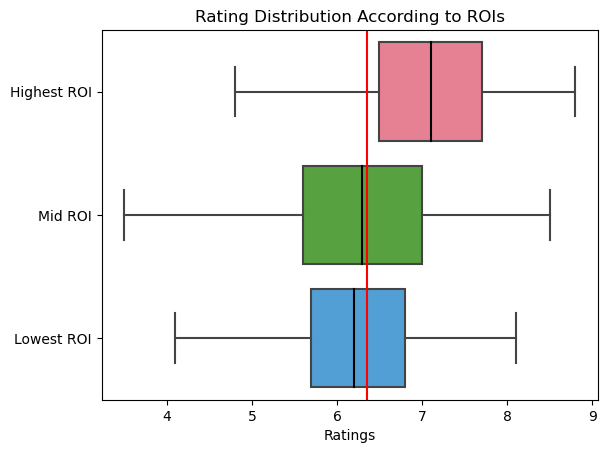

In [21]:
fig = sns.boxplot(
    data=concat_ROI,
    x='rating_average',
    y='Rank',
    medianprops={'color': 'black'},
    orient='h',
    showfliers=False,
    palette='husl'
    ).set(title='Rating Distribution According to ROIs')
plt.xlabel('Ratings')
plt.ylabel('')

# This vertical line represents the mean. It is calculated below.
plt.axvline(6.35, color='red')

We can plot the distribution of the different ratings given a ROI by using Seaborn's `histplot()`. This will allow us to observe any outliers and skewness.

In [22]:
# Function to plot the distribution curve
def distribution(df, title):
    sns.set(rc={'figure.figsize':(10,5)})
    sns.set_style('white')
    return sns.histplot(df, kde=True, bins=20).set_title(title, fontsize=15);

Text(0.5, 1.0, 'Rating Distribution for Top Films')

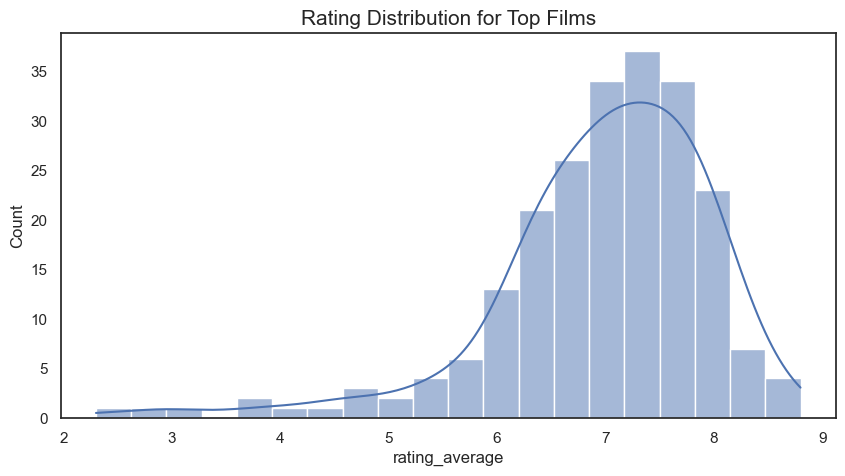

In [23]:
distribution(top_ROI['rating_average'], 'Rating Distribution for Top Films')

Text(0.5, 1.0, 'Rating Distribution for Mid Films')

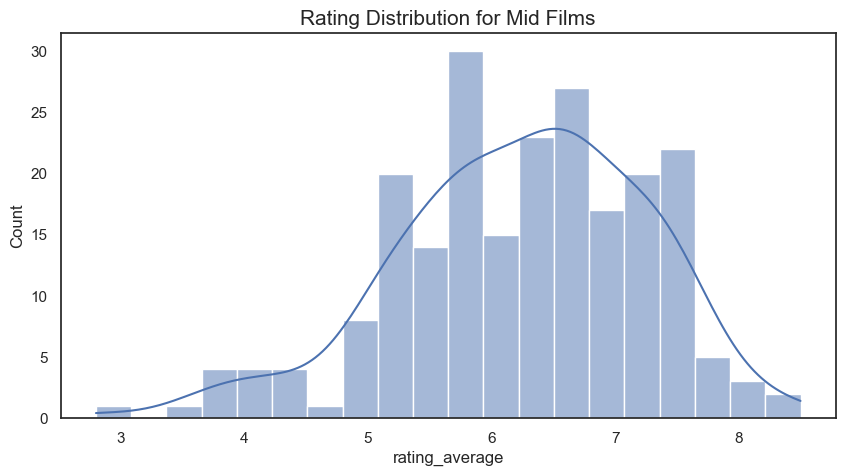

In [24]:
distribution(mid_ROI['rating_average'], 'Rating Distribution for Mid Films')

Text(0.5, 1.0, 'Rating Distribution for Bottom Films')

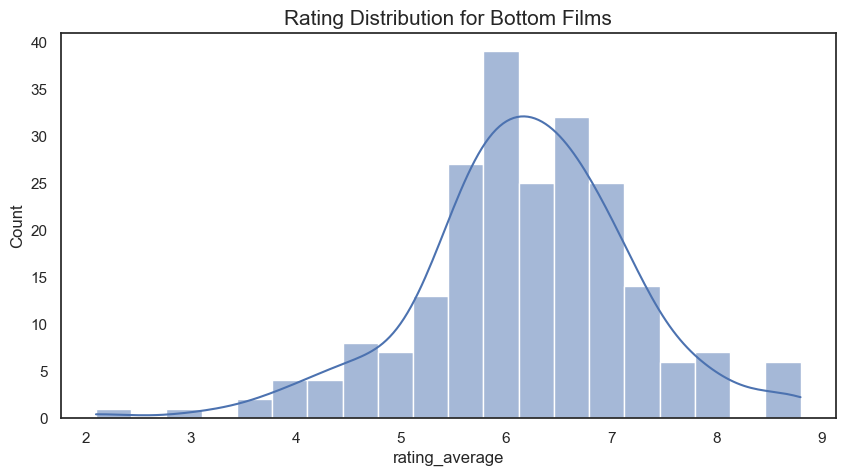

In [25]:
distribution(bot_ROI['rating_average'], 'Rating Distribution for Bottom Films')

Here, we can conclude that ratings generally do play a role in ROI. More than 75% of the high ROI films had ratings that were higher than the average rating. However, if the film fails to earn a high rating it can yield a mid or low ROI.

__Creating a scatterplot graph that shows which directors had the highest ROI__

Obtaining some values for specific directors.
* To find if a particular director is in the data we used `.str.contains(**director name**)`
* We can then concatenate all of these directors together

In [26]:
def name_df(df, occupation, names):
    # Create a dataframe based on the first name of the list
    names_df = df.loc[df[occupation].str.contains(names[0])]
    # A for loop that iterates through the list starting from the second to the last element
    for e in range(1, len(names)):
        # Locate the director of a specific name then concatenate to a the previous dataframe
        name = df.loc[df[occupation].str.contains(names[e])]
        names_df = pd.concat([names_df, name])
    return names_df

In [27]:
list_names = ['Joe Russo', 'Whedon', 'J.J. Abrams', 'Steven Spielberg', 'James Wan', 'Michael Bay']

some_directors = name_df(directors_merged, 'director', list_names)

Create the scatterplot graph that plots the ROIs of these directors relative to the `top_director`.

In [28]:
def scatterplot(df, some_df, field, title):
    fig = plt.figure(figsize=(20,12), dpi=100)

    fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

    top = sns.scatterplot(x='rating_average', y='ROI', data=df, legend='full', alpha=0.8, s=100, palette='Set2')
    sample = sns.scatterplot(x='rating_average', y='ROI', data=some_df, legend='full', s=200, hue=field, palette='Set2', marker='s')

    ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
    ax.yaxis.set_minor_locator(MultipleLocator(50000000))
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    fig.suptitle(title, fontweight='bold', fontsize=26)
    ax.set_xlabel("Ratings", fontsize=20, fontweight='bold')
    ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

    plt.legend(fontsize=20)

    plt.tight_layout();

<Figure size 2000x1200 with 0 Axes>

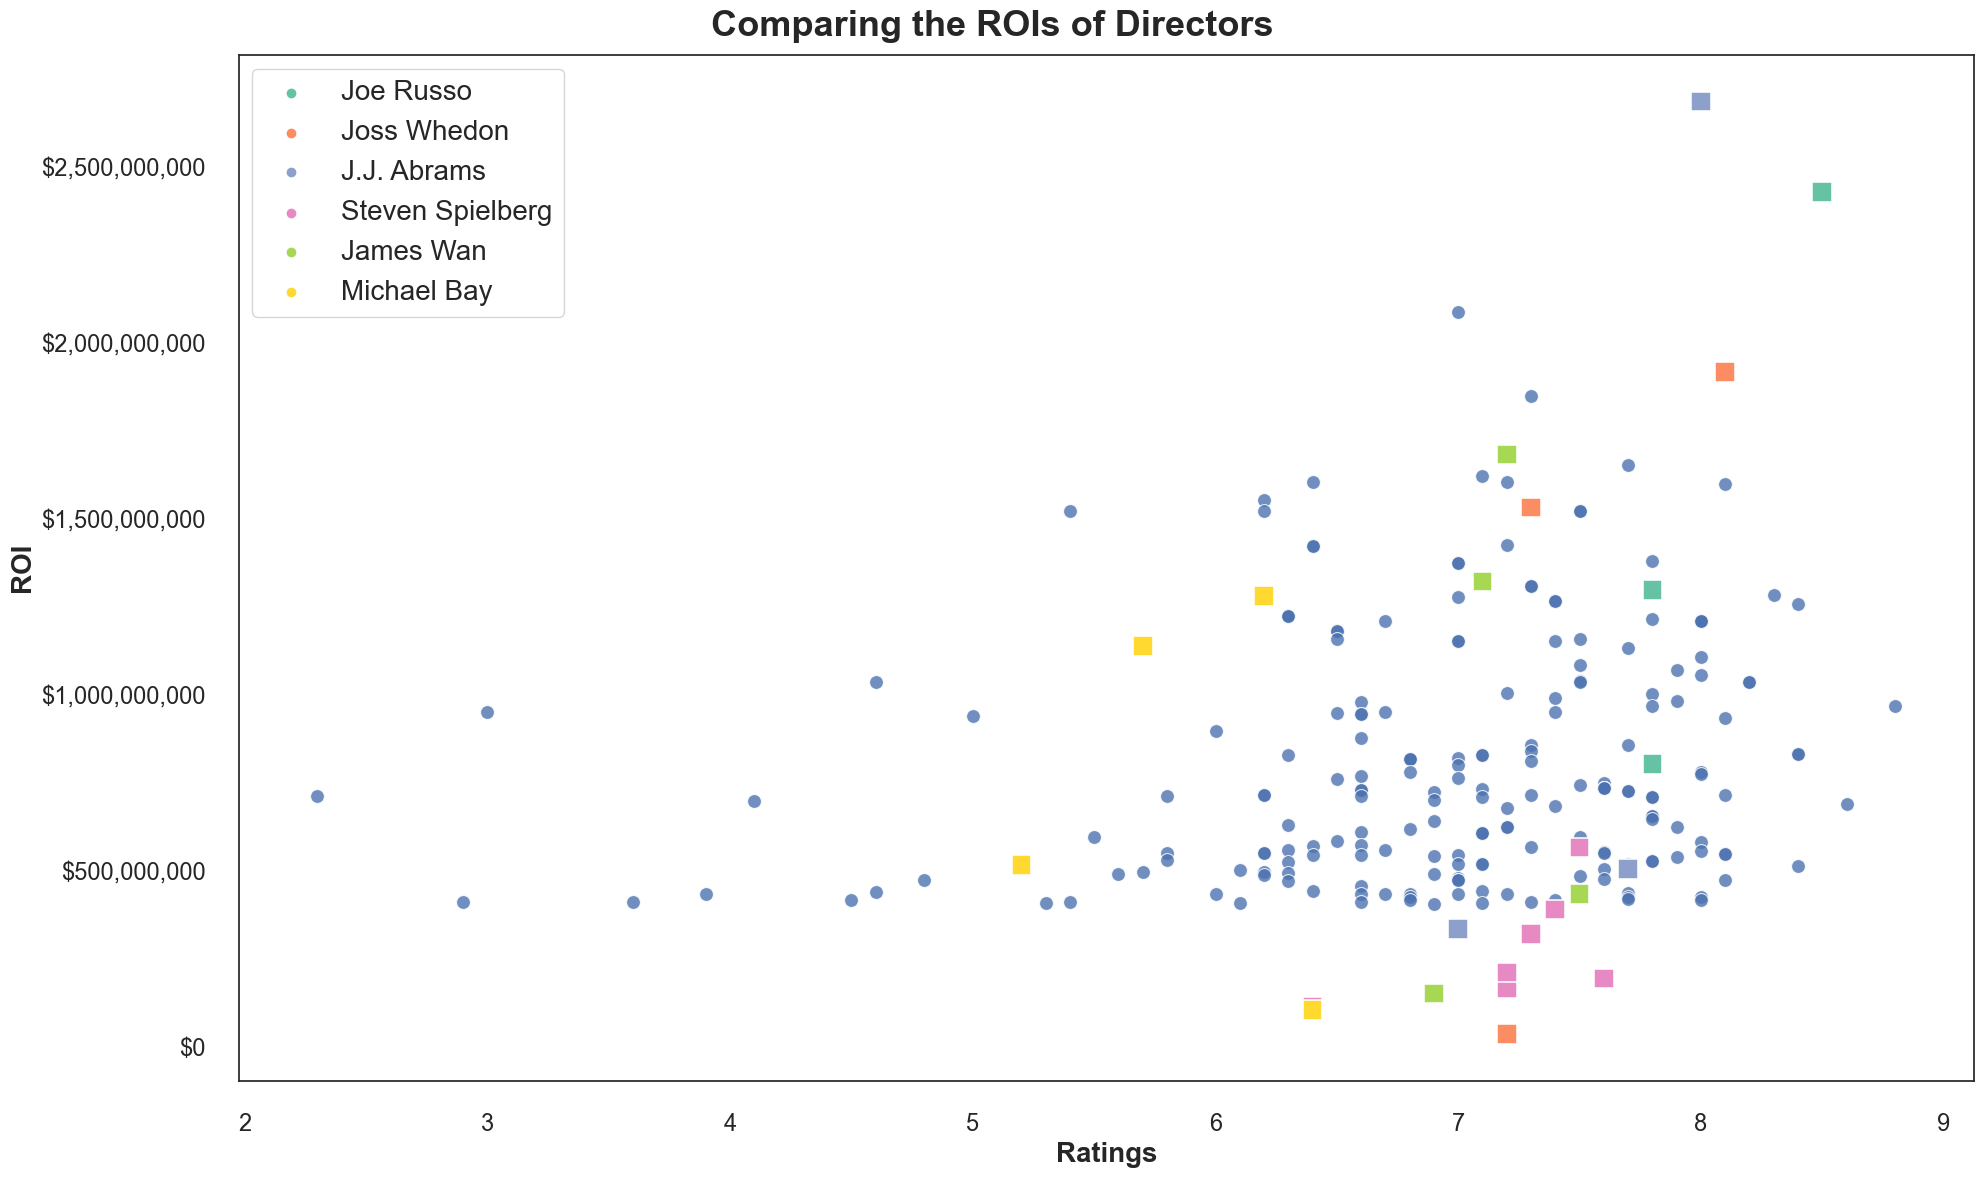

In [29]:
scatterplot(top_ROI, some_directors, 'director', "Comparing the ROIs of Directors")

From this graph we can clearly see that Michael Bay, who directed the _Transformer_ series, averaged higher ROIs than Steven Spielberg despite Bay's subpar ratings. It really shows the dominance film series have over the market.

__Creating a bar graph for select directors__

In [30]:
def average_profit(df, occupation, name):
    # Calculates the average profit of films with starring specific people
    return df.loc[df[occupation].str.contains(name)]['ROI'].mean()

In [31]:
average_profit_directors = {'Joe Russo': average_profit(some_directors, 'director', 'Russo'),
                            'Joss Whedon': average_profit(some_directors, 'director', 'Whedon'),
                            'J.J. Abrams': average_profit(some_directors, 'director', 'Abrams'),
                            'Steven Spielberg': average_profit(some_directors, 'director', 'Spielberg'),
                            'James Wan': average_profit(some_directors, 'director', 'Wan'),
                            'Michael Bay': average_profit(some_directors, 'director', 'Bay')}
average_profit_directors

{'Joe Russo': 1509750763.6666667,
 'Joss Whedon': 1161577983.6666667,
 'J.J. Abrams': 1175036871.3333333,
 'Steven Spielberg': 281059158.85714287,
 'James Wan': 897866644.75,
 'Michael Bay': 760467960.75}

In [32]:
def bargraph(average, title, field):
    fig = plt.figure(figsize=(20,12), dpi=100)

    fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

    plt.bar(average.keys(), average.values())

    ax.yaxis.set_major_locator(MultipleLocator(500000000.00))
    ax.yaxis.set_minor_locator(MultipleLocator(50000000))
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    fig.suptitle(title, fontweight='bold', fontsize=26)
    ax.set_xlabel(field, fontsize=20, fontweight='bold')
    ax.set_ylabel("ROI", fontsize=20, fontweight='bold')

    plt.tight_layout()

<Figure size 2000x1200 with 0 Axes>

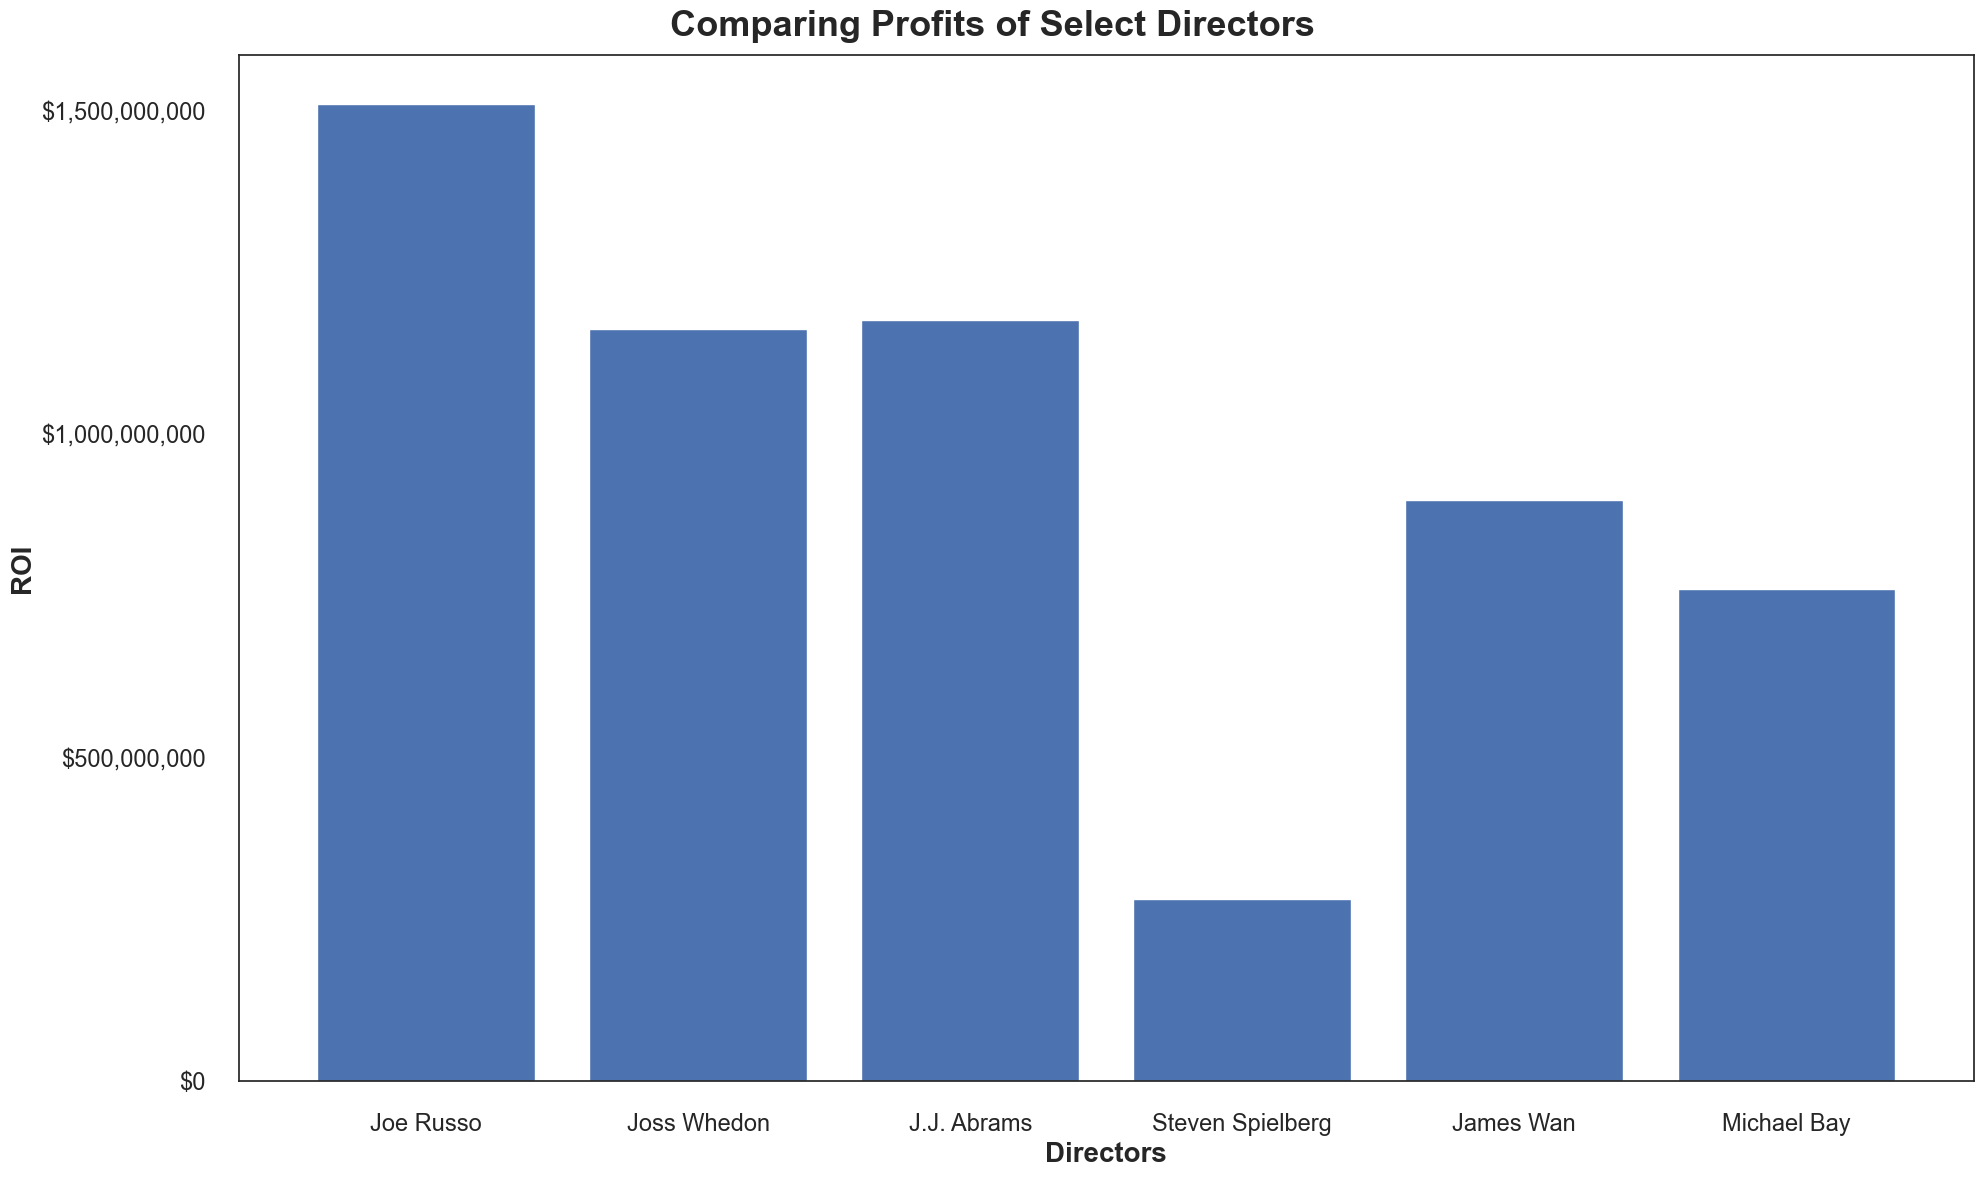

In [33]:
bargraph(average_profit_directors, "Comparing Profits of Select Directors", 'Directors')

__Creating a scatterplot for writers__

In [34]:
#Some names of writers including both originals and series
writer_names = ['Quentin Tarantino', 'George Lucas', 'Joel Coen', 'Christopher Markus', 'Christopher Nolan', 'Ken Daurio']

some_writers = name_df(writers_merged, 'writer', writer_names)

<Figure size 2000x1200 with 0 Axes>

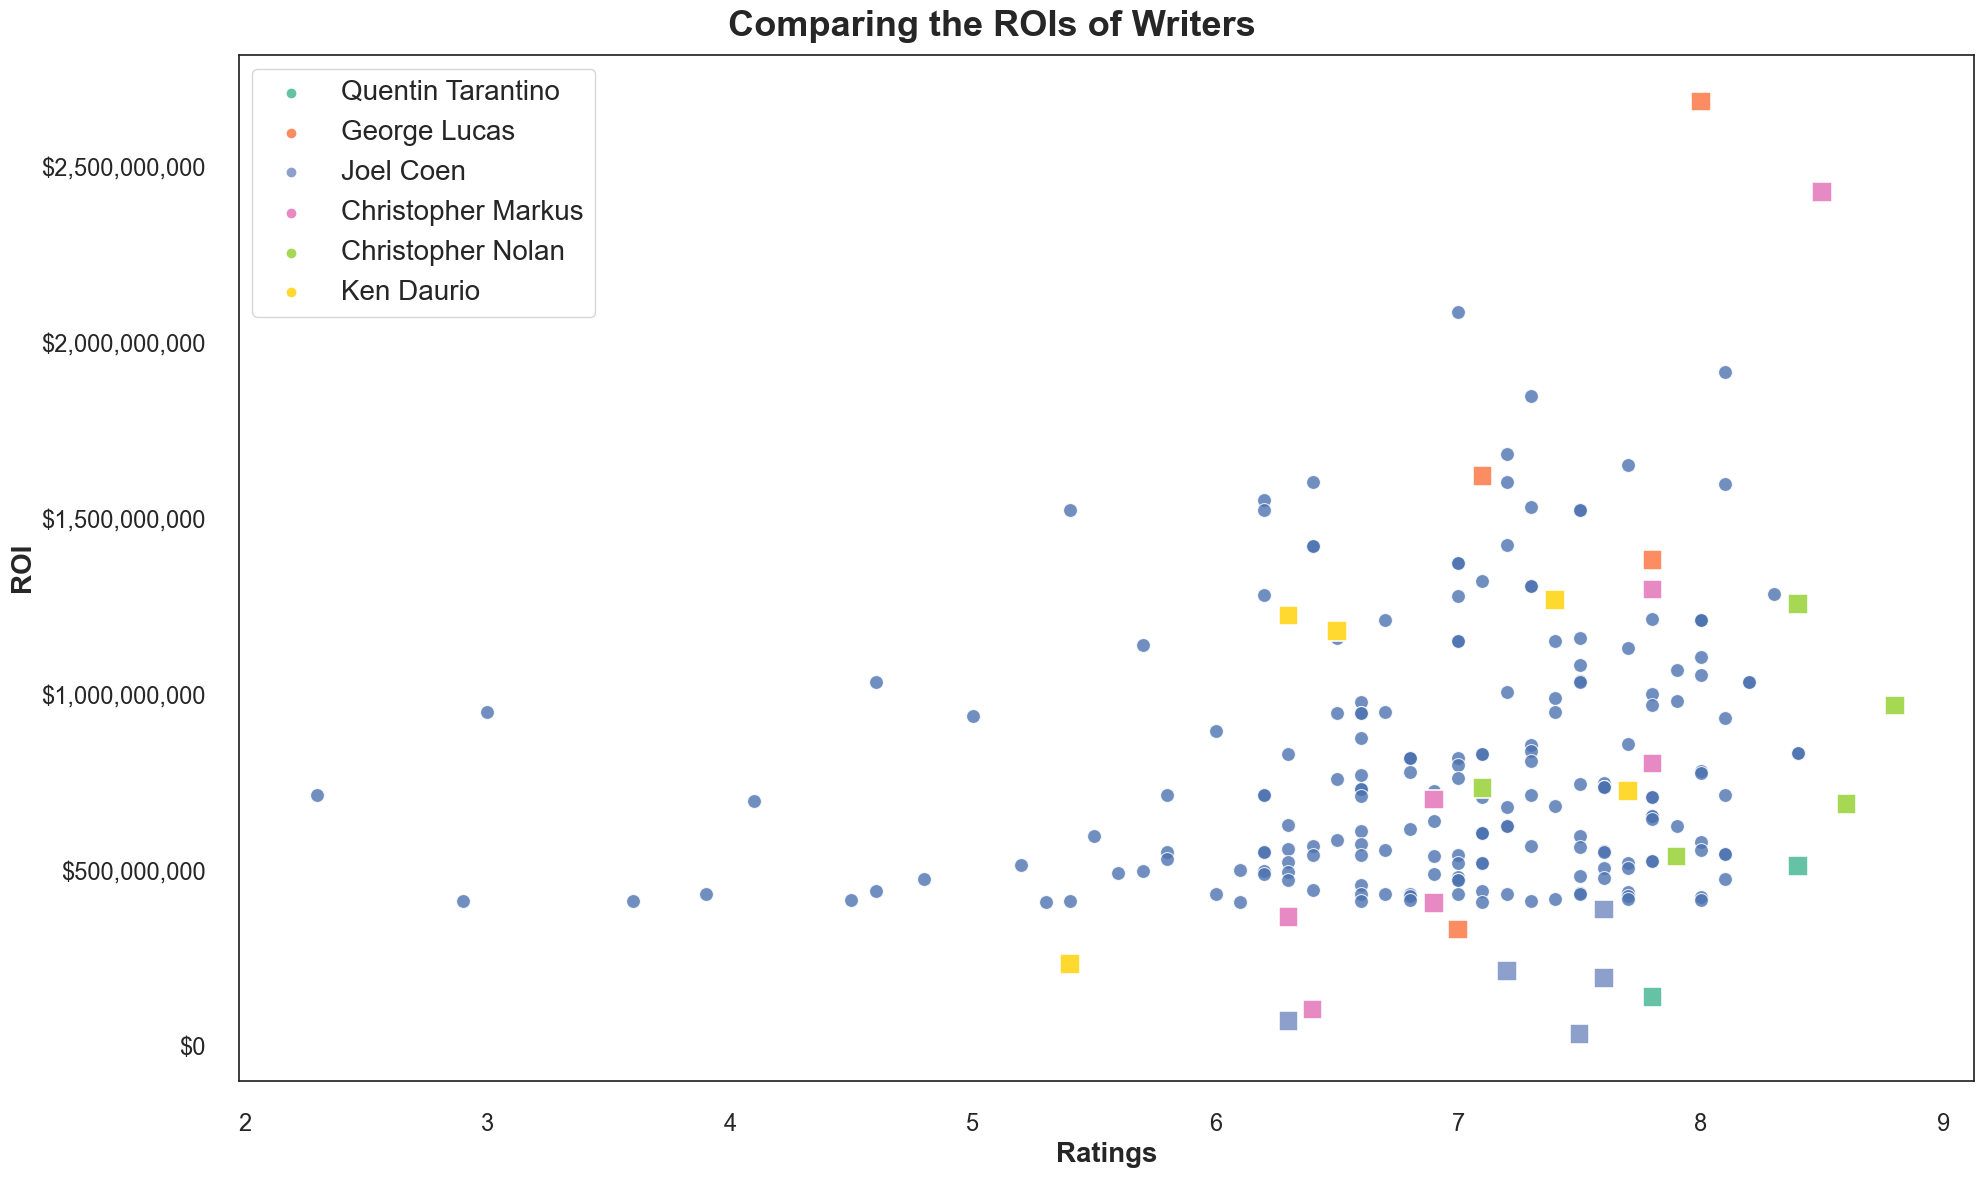

In [35]:
scatterplot(top_ROI, some_writers, 'writer', "Comparing the ROIs of Writers")

Again, the graph shows the strength of films series in the market. It allows us to compare Ken Daurio's _Despicable Me_ to the scripts of the Coen brothers.

__Creating a bar graph for select writers__

In [36]:
average_profit_writers = {'Quentin Tarantino': average_profit(some_writers, 'writer', 'Quentin'),
                          'George Lucas': average_profit(some_writers, 'writer', 'Lucas'),
                          'Joel Coen': average_profit(some_writers, 'writer', 'Coen'),
                          'Christopher Markus': average_profit(some_writers, 'writer', 'Markus'),
                          'Christopher Nolan': average_profit(some_writers, 'writer', 'Nolan'),
                          'Ken Daurio': average_profit(some_writers, 'writer', 'Daurio')}
average_profit_writers

{'Quentin Tarantino': 326368029.5,
 'George Lucas': 1504268903.25,
 'Joel Coen': 180986021.0,
 'Christopher Markus': 872880815.7142857,
 'Christopher Nolan': 837805397.6,
 'Ken Daurio': 926298118.0}

<Figure size 2000x1200 with 0 Axes>

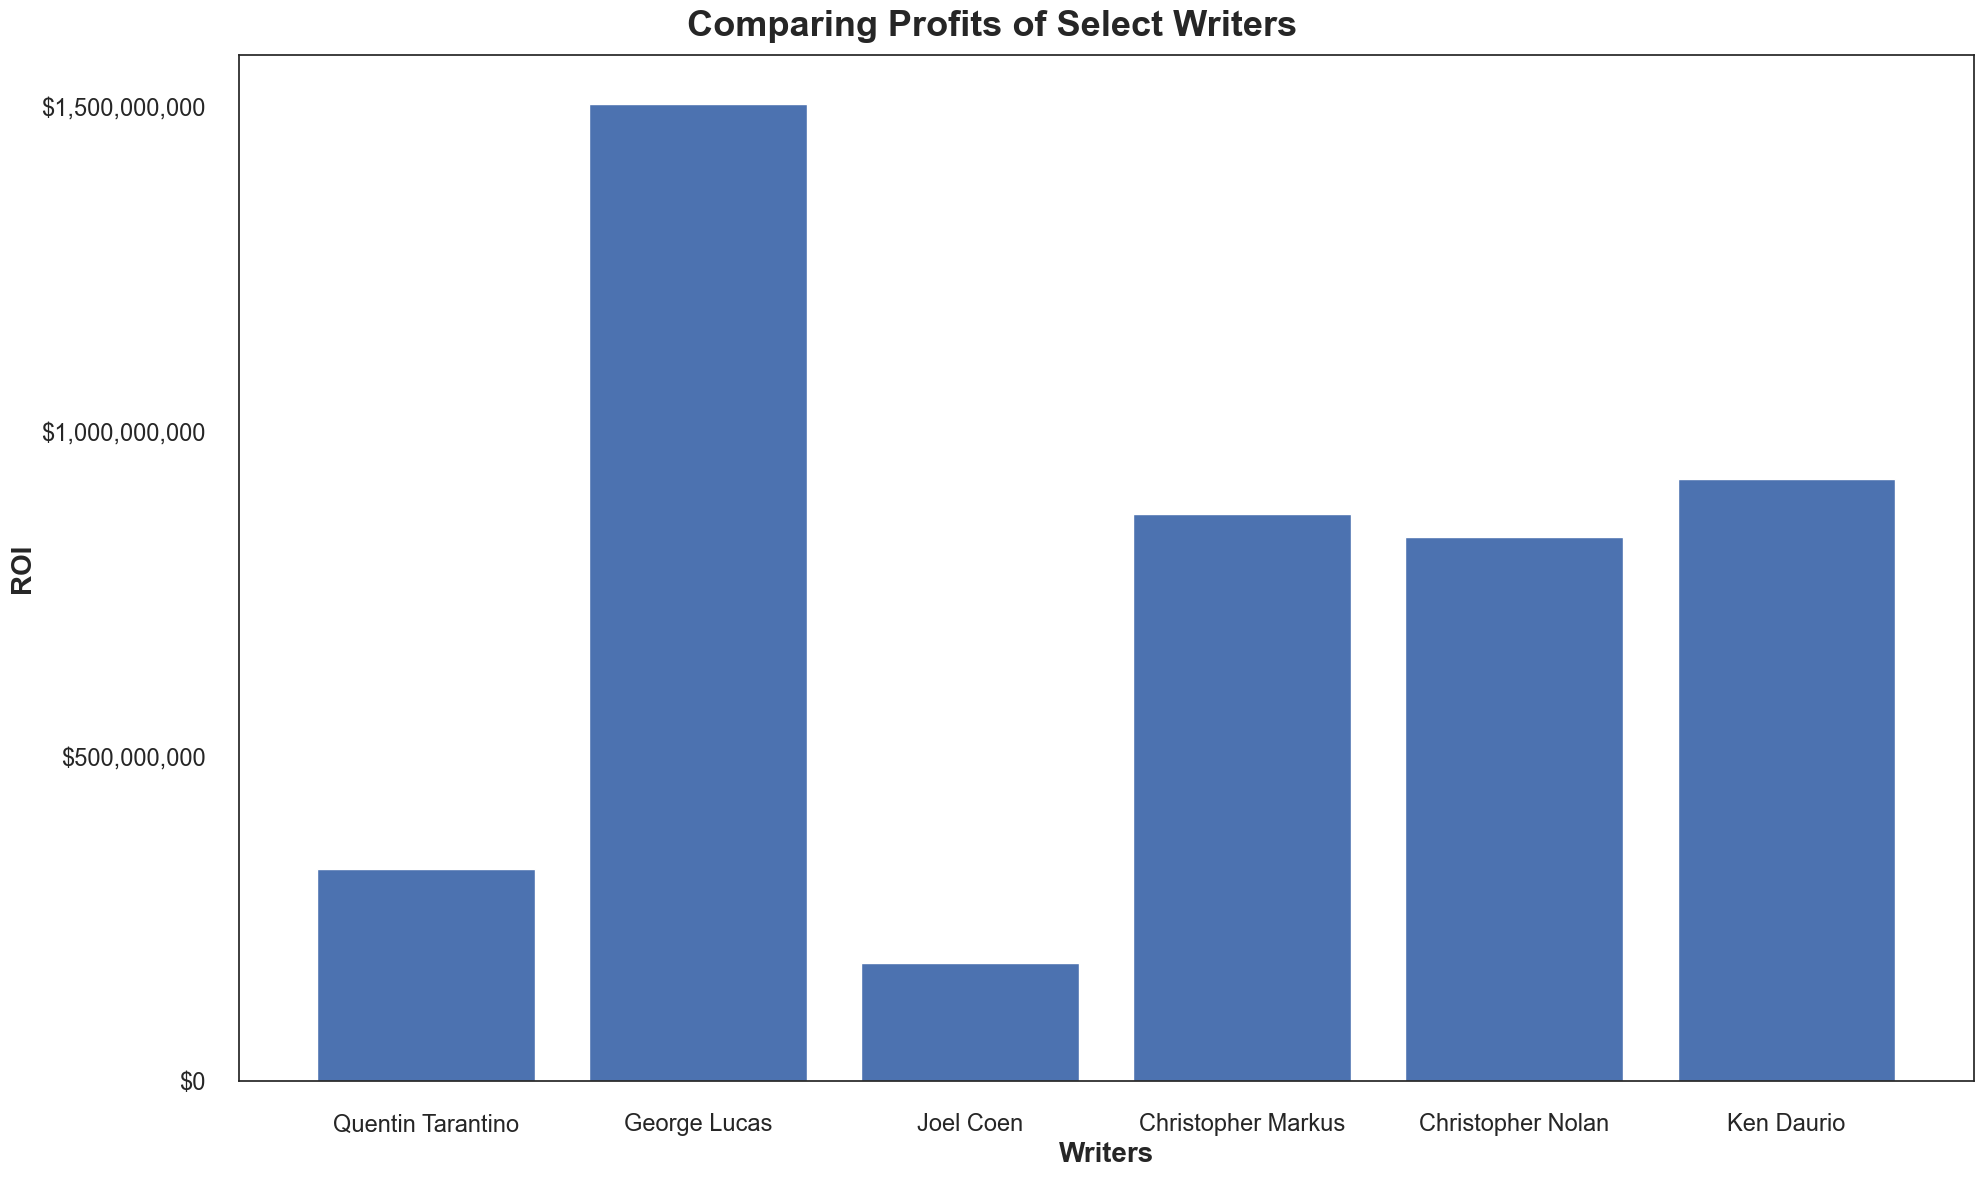

In [37]:
bargraph(average_profit_writers, "Comparing Profits of Select Writers", 'Writers')

__Creating a scatterplot for actors/actresses__

In [38]:
#A sample of actors/actresses involved in originals and series.
renown_names = ['Brad Pitt', 'Chris Evans', 'Jennifer Lawrence', 'Leonardo DiCaprio', 'Vin Diesel', 'Daniel Craig']

some_renown = name_df(renown_merged, 'renown', renown_names)

<Figure size 2000x1200 with 0 Axes>

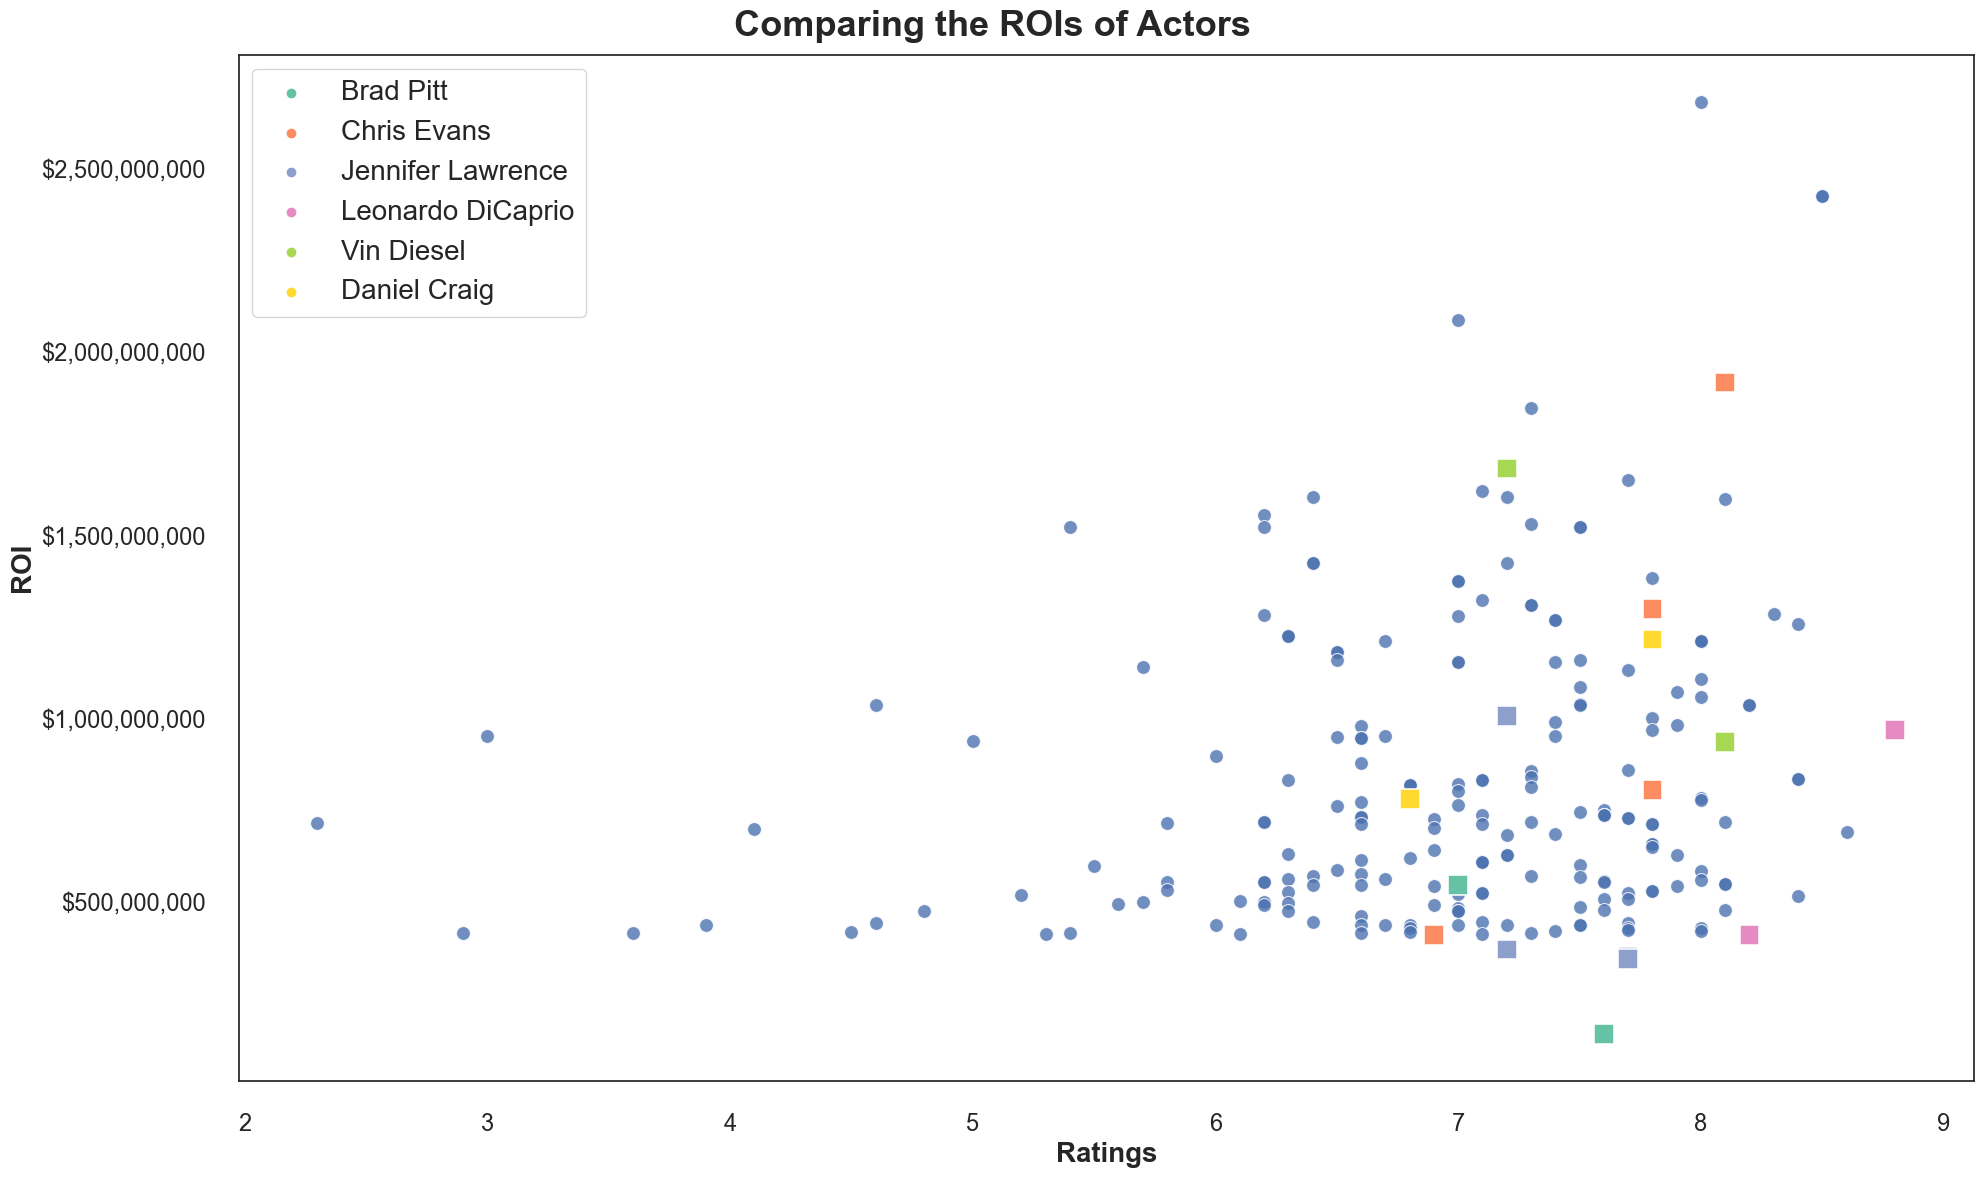

In [39]:
scatterplot(top_ROI, some_renown, 'renown', "Comparing the ROIs of Actors")

Same story, different category. We see actors/actresses who work in series earning higher ROI than their competitors. The fact that films with Vin Diesel (_Fast and Furious_) makes more than triple of films starring Brad Pitt really forces the theme that film series can return profit despite having two-dimensional acting. 

__Creating a bar graph for select actors__

In [40]:
average_profit_actors = {'Brad Pitt': average_profit(some_renown, 'renown', 'Pitt'),
                          'Chris Evans': average_profit(some_renown, 'renown', 'Evans'),
                          'Jennifer Lawrence': average_profit(some_renown, 'renown', 'Lawrence'),
                          'Leonardo DiCaprio': average_profit(some_renown, 'renown', 'DiCaprio'),
                          'Vin Diesel': average_profit(some_renown, 'renown', 'Diesel'),
                          'Daniel Craig': average_profit(some_renown, 'renown', 'Craig')}
average_profit_actors

{'Brad Pitt': 340390344.0,
 'Chris Evans': 1106435583.5,
 'Jennifer Lawrence': 515813048.25,
 'Leonardo DiCaprio': 687435972.5,
 'Vin Diesel': 1307884721.0,
 'Daniel Craig': 997291178.0}

<Figure size 2000x1200 with 0 Axes>

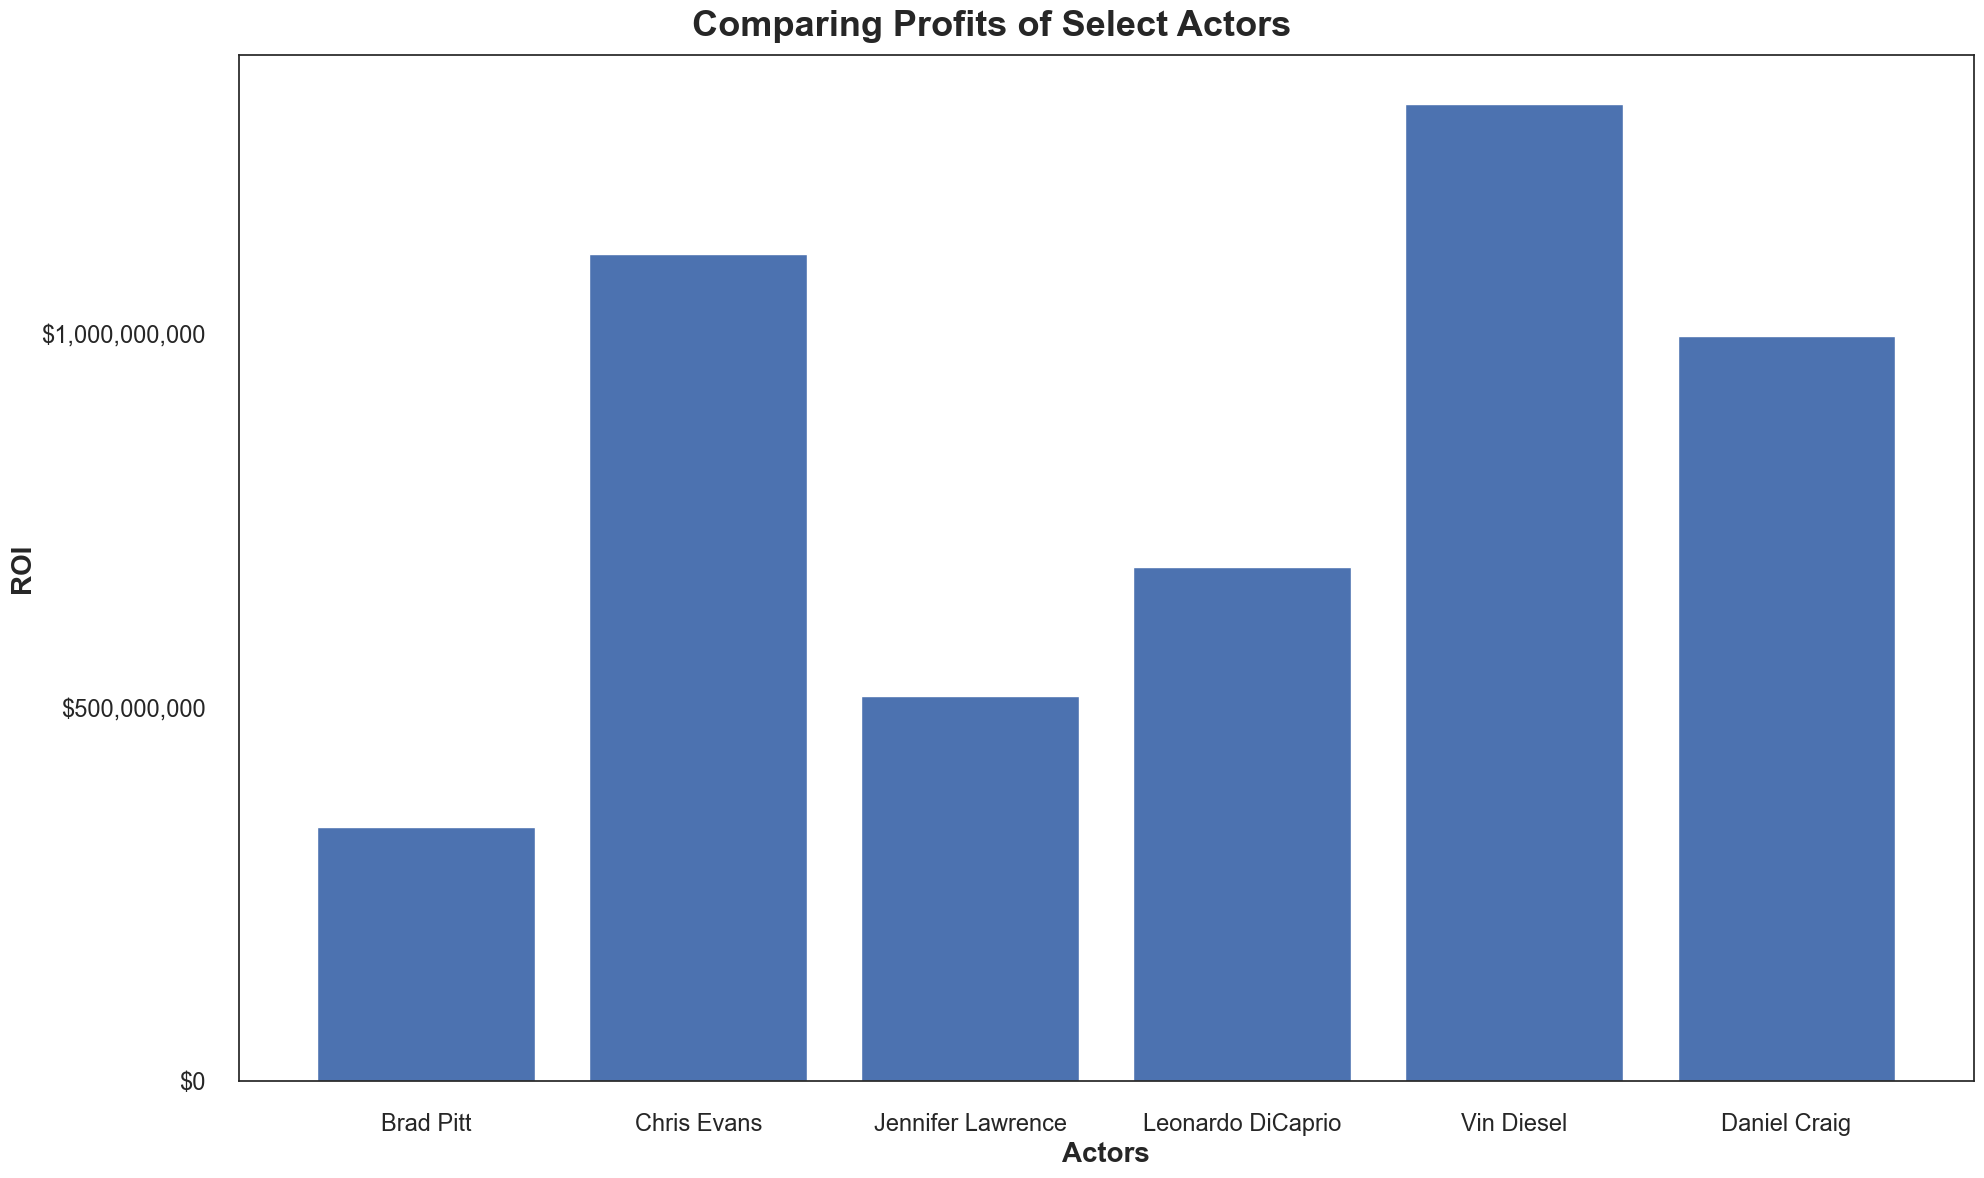

In [41]:
bargraph(average_profit_actors, "Comparing Profits of Select Actors", 'Actors')

__Creating a histogram that relates genre to ROI__
* We can obtain values of specific genres by using the same method: `.str.contains(**genre**)`
* Then use `.assign(Genre='genre')` to create a new column of genre values.
* To maintain brevity, we will make a similar function as before

In [42]:
def genres(df):
    genres = ['Action', 'Adventure', 'Sci-Fi', 'Comedy', 'Drama', 'Fanstasy', 'Animation', 'Horror', 'Family']
    genre_df = df.loc[df['genres'].str.contains(genres[0])].assign(Genre=genres[0])
    for e in range(1, len(genres)):
        genre = df.loc[df['genres'].str.contains(genres[e])].assign(Genre=genres[e])
        genre_df = pd.concat([genre_df, genre])
    return genre_df

In [43]:
concat_genres = genres(directors_merged)

In [44]:
def histplot(df, title):
    fig = plt.figure(figsize=(20,12), dpi=100)

    fig, ax = plt.subplots(figsize=(20,12), dpi=100, facecolor='w', edgecolor='k')

    graph = sns.histplot(data=df)

    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    fig.suptitle(title, fontweight='bold', fontsize=26)
    ax.set_xlabel("Genre", fontsize=20, fontweight='bold')
    ax.set_ylabel("Count", fontsize=20, fontweight='bold')

<Figure size 2000x1200 with 0 Axes>

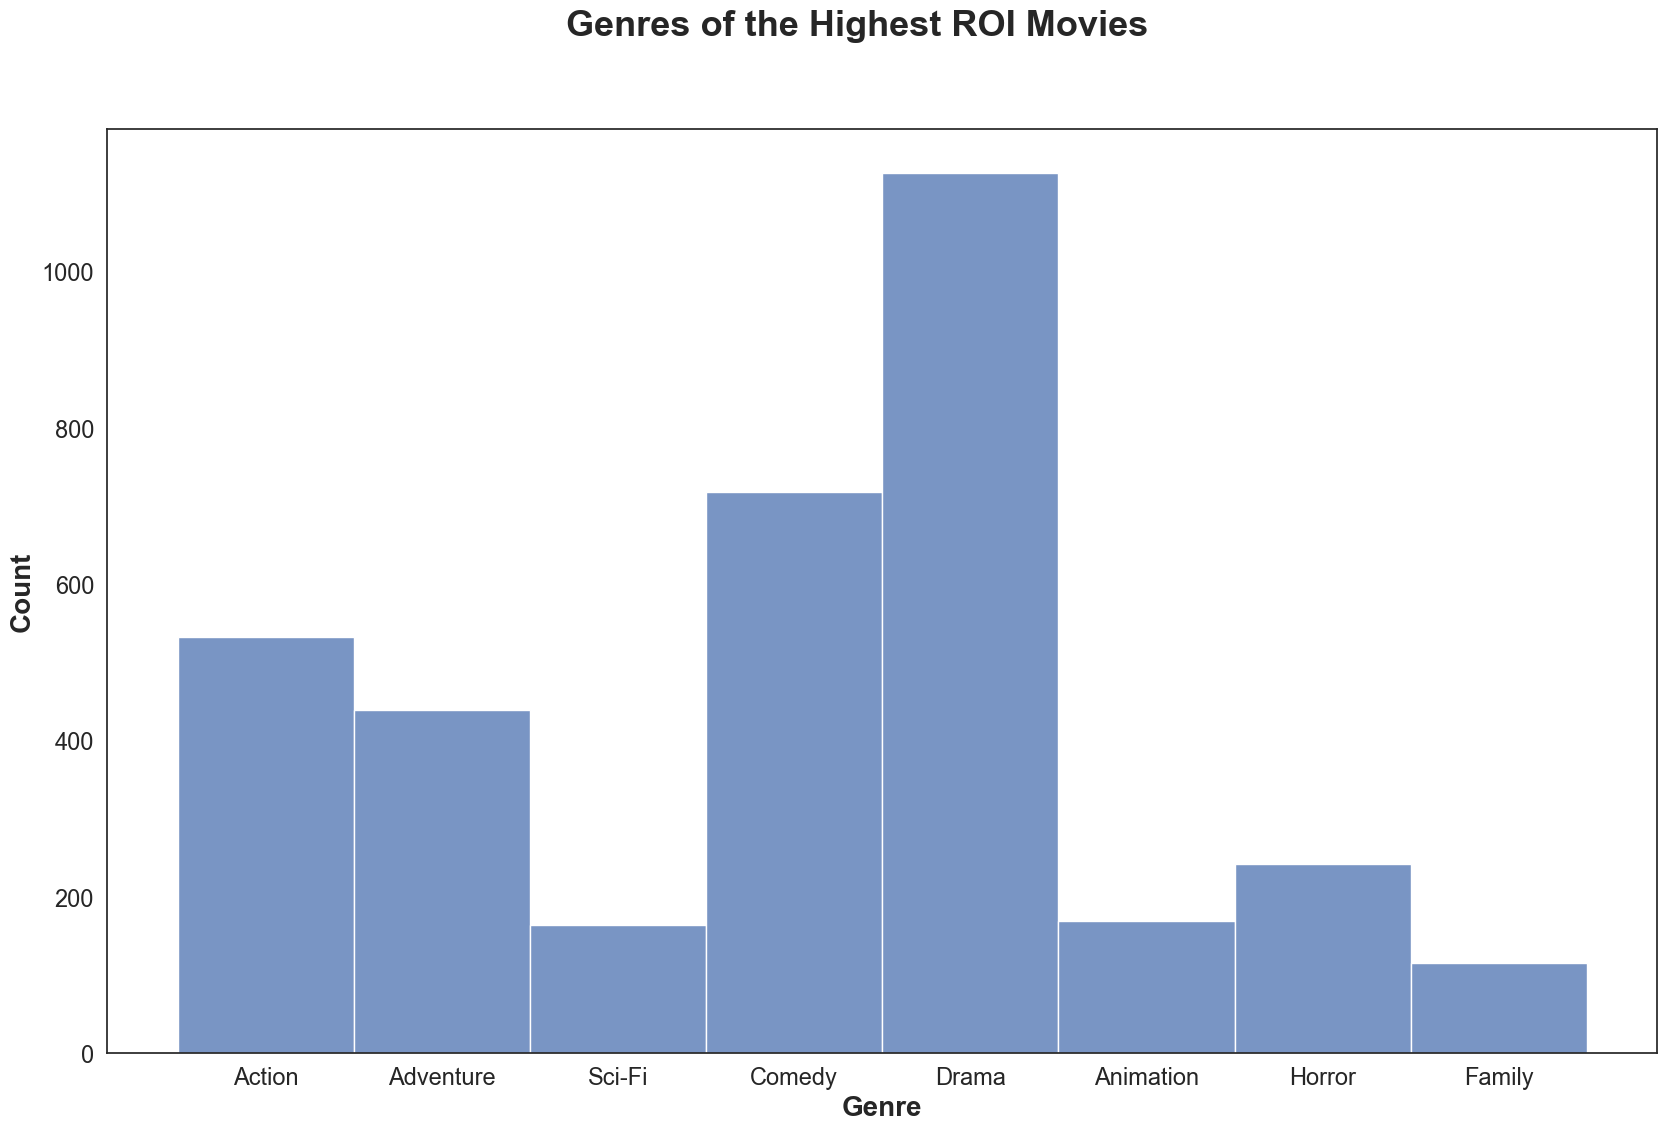

In [45]:
histplot(concat_genres.Genre, 'Genres of the Highest ROI Movies')

The histograms reveals which genres are most prevalent in this data set. The high amounts of action and adventure films are most likely due to the high concentration of popular series like Marvel and Star Wars. 

__Creating a histogram based on percent change__

Having a high ROI is not the only metric of measuring a film's success. We can also measure the film's percent change. This can level the playing field for non-blockbuster films that did well relative to their production budget. <br>We will create two dataframes that contains genres with the highest and the lowest percent change. <br>We should use the same genres as the previous histogram so we can observe the differences.

In [46]:
# Using the data from the directors dataframe, but writers and famousppl should work the same.
ROI_percent = directors_merged.sort_values(by='Percent_change', ascending=False)

top_genres = ROI_percent.iloc[:220]
bot_genres = ROI_percent.sort_values(by='Percent_change', ascending=True).iloc[:220]

We can now run these dataframes into the genre function.

In [47]:
concat_percent = genres(top_genres)
concat_bot_percent = genres(bot_genres)

Create the histogram

<Figure size 2000x1200 with 0 Axes>

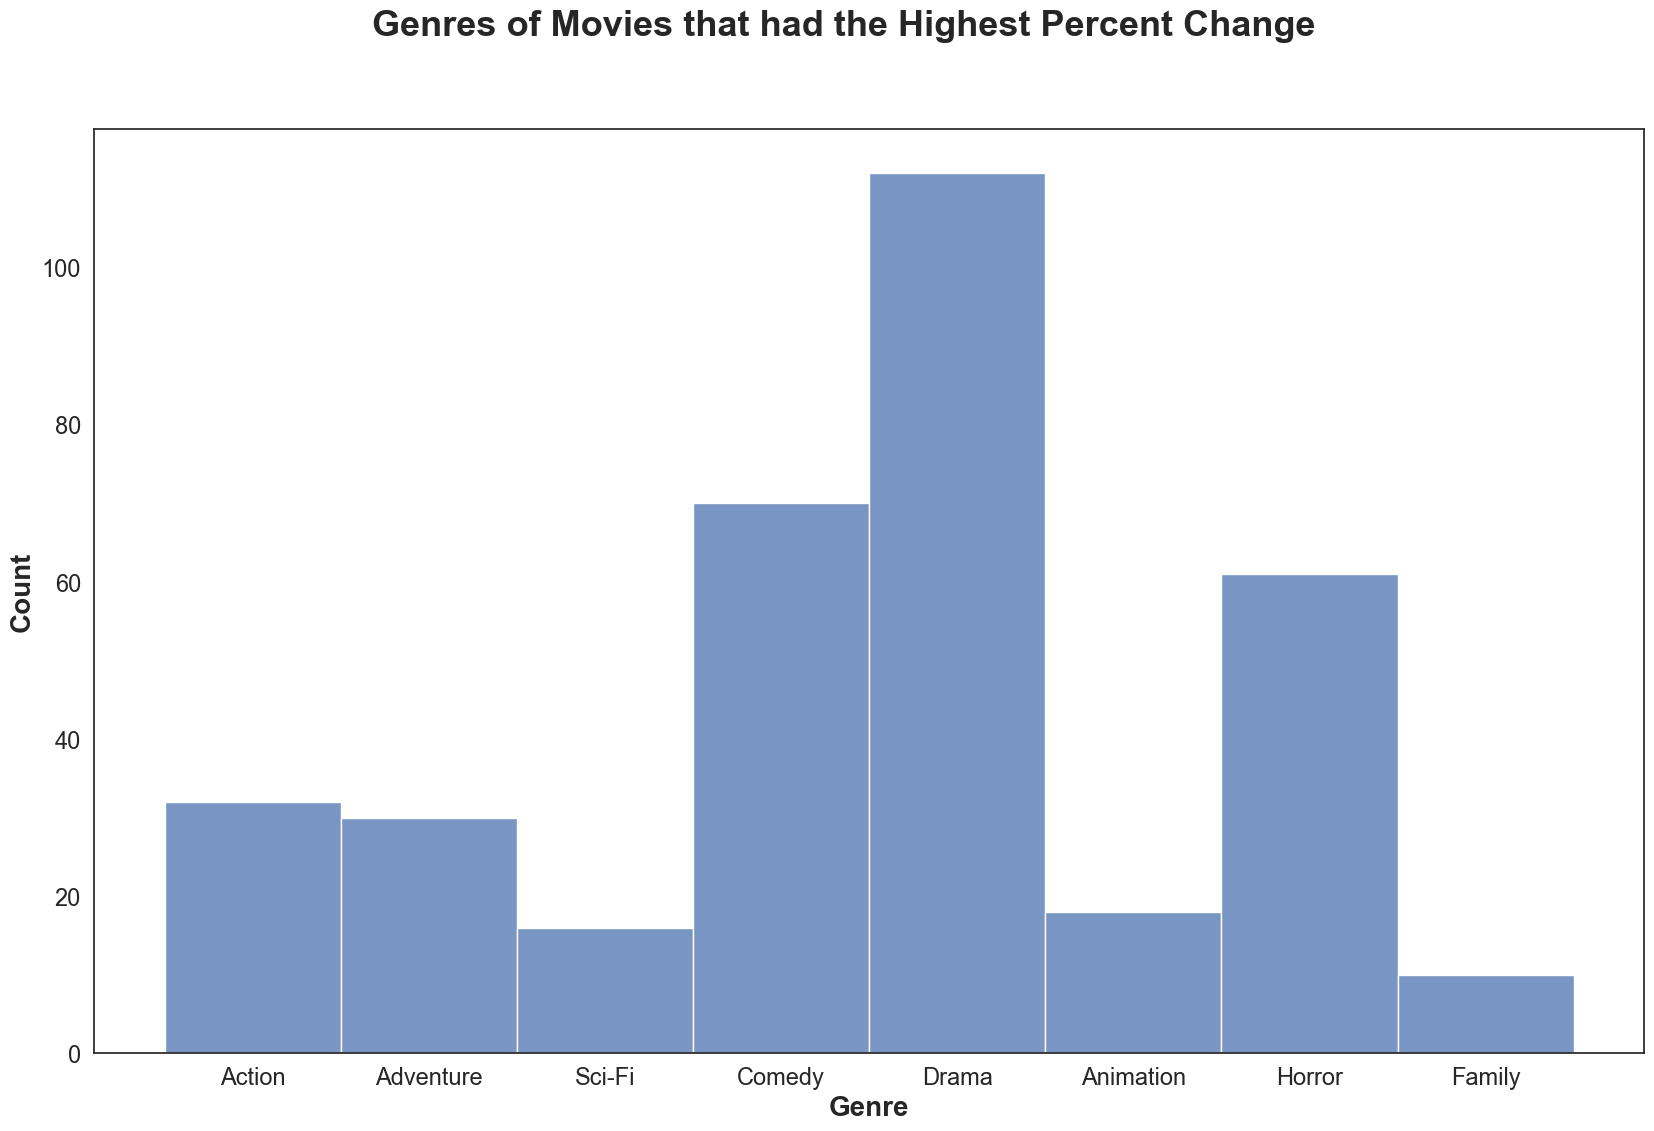

In [48]:
histplot(concat_percent.Genre, 'Genres of Movies that had the Highest Percent Change')

Popular action series do require a high budget and while it does return a great profit, does it return the highest percentage? This chart indicates otherwise.

<Figure size 2000x1200 with 0 Axes>

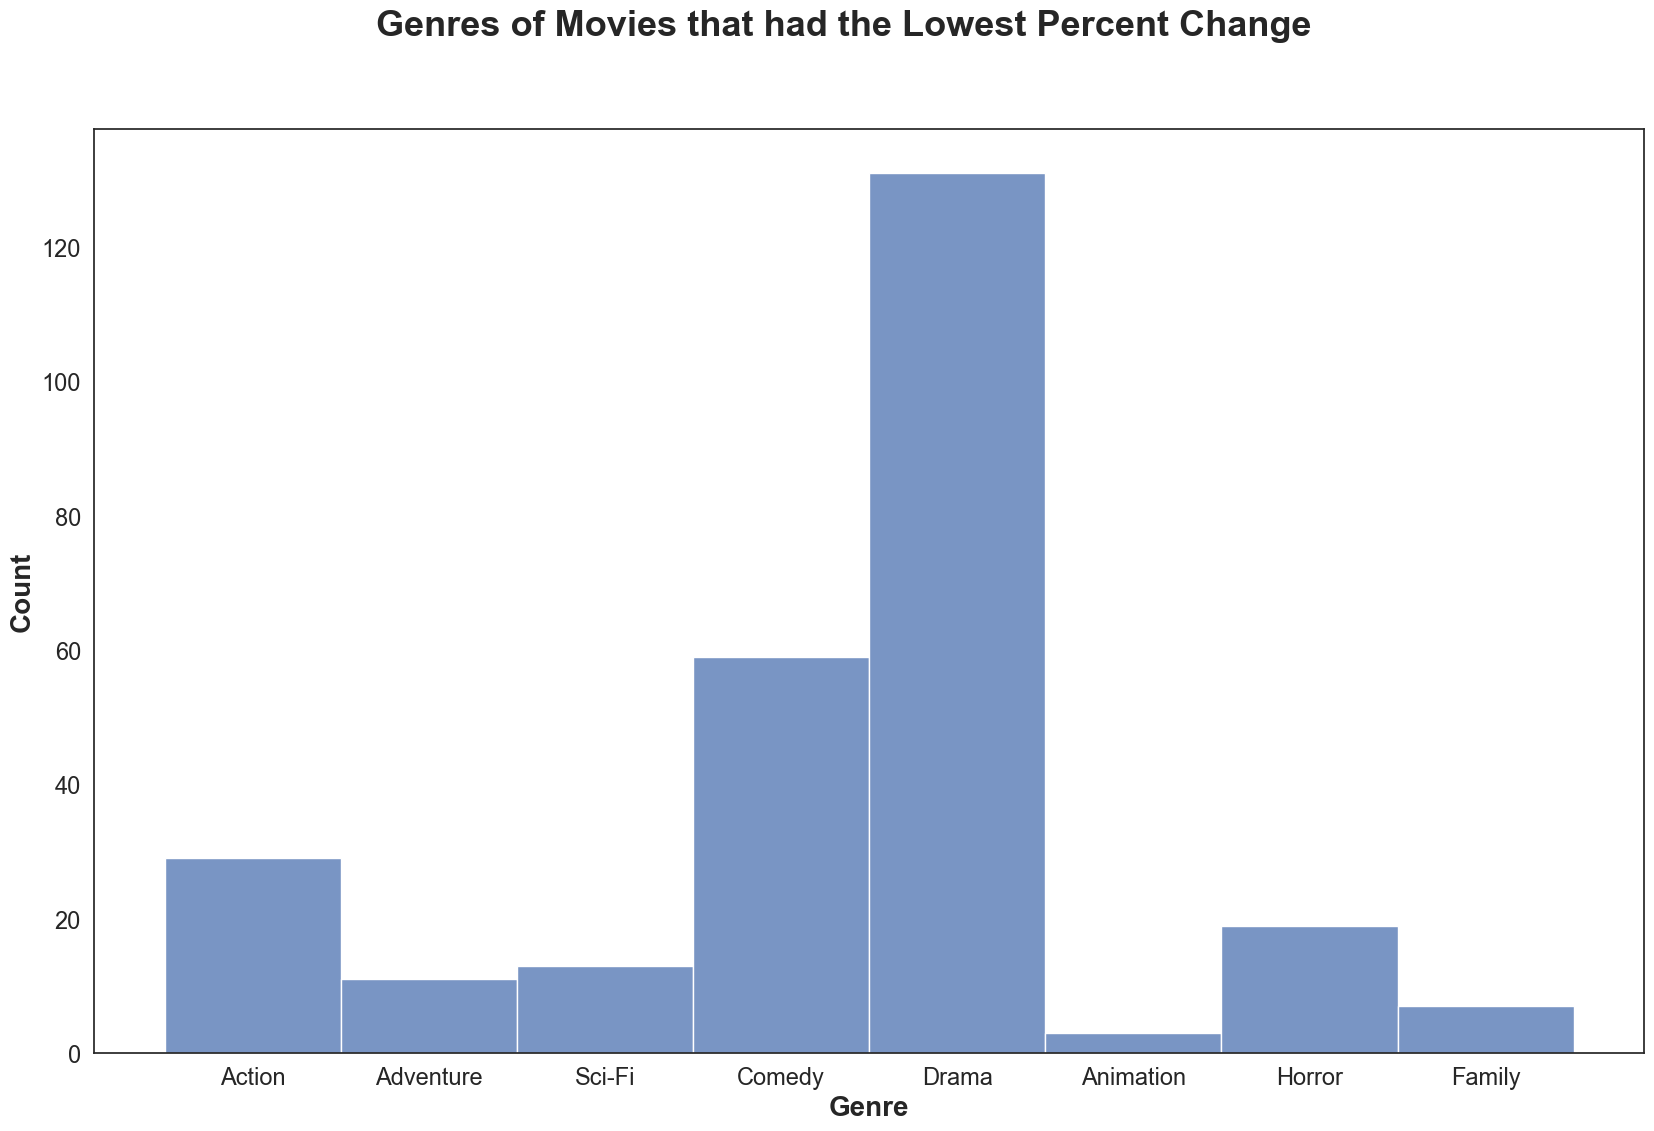

In [49]:
histplot(concat_bot_percent.Genre, 'Genres of Movies that had the Lowest Percent Change')

However, it seems like investing in comedy or drama films may be bit of a gamble whereas horror films seem like a safer bet.

# Calculating the Mean

Finally we can calculate the mean for ROI, budget, and percent change.

In [50]:
print('This is the average production budget of all films: ${:,.2f}'.format(directors_merged['production_budget'].mean()))
print('This is the average profit of all films: ${:,.2f}'.format(directors_merged['ROI'].mean()))
print('This is the average rating of all films:', directors_merged['rating_average'].mean())
print('This is the average percent increase for all films: ', directors_merged['Percent_change'].mean())

This is the average production budget of all films: $42,685,223.53
This is the average profit of all films: $147,554,454.22
This is the average rating of all films: 6.31767653758541
This is the average percent increase for all films:  540.5598429581969


In [51]:
print('This is the average production budget for movies with the greatest ROI: ${:,.2f}'.format(top_ROI['production_budget'].mean()))
print('This is the average profit for movies with the greatest ROI: ${:,.2f}'.format(top_ROI['ROI'].mean()))
print('This is the average rating for movies with the greatest ROI:', top_ROI['rating_average'].mean())
print('This is the average percent increase for movies with the greatest ROI: ', top_ROI['Percent_change'].mean())

This is the average production budget for movies with the greatest ROI: $139,247,511.31
This is the average profit for movies with the greatest ROI: $840,362,964.38
This is the average rating for movies with the greatest ROI: 6.980542986425336
This is the average percent increase for movies with the greatest ROI:  953.1306931357367


In [52]:
print('This is the average production budget for the movies with the greatest percent change: ${:,.2f}'.format(top_genres['production_budget'].mean()))
print('This is the average profit for the movies with the greatest percent change: ${:,.2f}'.format(top_genres['ROI'].mean()))
print('This is the average rating for movies with the greatest percent change:', top_genres['rating_average'].mean())
print('This is the average percent increase for the movies with the greatest percent change:', top_genres['Percent_change'].mean())

This is the average production budget for the movies with the greatest percent change: $16,030,030.23
This is the average profit for the movies with the greatest percent change: $270,475,655.32
This is the average rating for movies with the greatest percent change: 6.52272727272727
This is the average percent increase for the movies with the greatest percent change: 3333.9820113243195


# Conclusion
Film series do exceedingly well compared to original titles. This may be due to the cult following some series have (i.e. _Marvel_) as opposed to a new intellectual property. Because a new IP may not have the initial fanbase as _Star Wars_ does, studios should be more aware of who they hire as their director, writer, actors, etc. These element affect ratings which ultimately can determine a film's ROI.

On the otherhand, if a studio's objective is to have the greatest ROI without the care for ratings, they can look to different genres (i.e. horror). These are films with high ROI relative to their budget despite their lower ratings. This may be enticing to studios with lower liquidity as well.